In [1]:
import os, sys
import os.path as osp
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from pubchempy import get_compounds
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import umap
import torch
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from models.graphconv import MultiNetV3
from metrics.metrics import get_multilabel_metrics
from utils.dataset import MemoryDataset
from utils.params import reset_weights

In [2]:
CATEGORIES = {"cns": 0, "antineoplastic": 1, "cardio": 2, "gastrointestinal": 3, "antiinfective": 4, 
                "reproductivecontrol": 5, "lipidregulating": 6, "hematologic": 7, "respiratorysystem": 8,
               "antiinflammatory": 9, "urological": 10, "dermatologic": 11}

In [3]:
CATEGORIES_SHORT = ["CNS", "-Neo", "Cardio", "Gastro", "-Infec", "Repro", "LipReg", "Hema", "Resp", "-Infla", "Urol", "Derm"]

In [4]:
COLORS = ["darkorange", "darkgreen", "darkblue", "red", "darkviolet", "fuchsia", "black", "dimgray", "tan", "limegreen", "royalblue", "teal"]

In [5]:
COLORS_ = ["darkorange", "darkgreen", "darkblue", "red", "darkviolet", "fuchsia", "black", "dimgray", "#829356", "limegreen", "royalblue", "teal"]

In [6]:

LR = 0.001
NUM_SPLITS = 5
WORKERS = 12
PATIENCE = 30
NUM_EPOCHS = 200
GPU = 0

BATCH_SIZE = 512
NUM_CLASSES = 12
BASE_DIR = os.getcwd()
DATA_DIR = osp.join(BASE_DIR, 'data')
OLD_DATA_DIR = osp.join(DATA_DIR, "multiclass_data")
OLD_DATA_FILE = osp.join(OLD_DATA_DIR, 'all_chem_df.csv')
PROCESSED_DATA_DIR = osp.join(OLD_DATA_DIR, 'processed')
DATA_PATH = osp.join(PROCESSED_DATA_DIR, f'TrainValGraphsData')
SAVED_MODELS_DIR = osp.join(BASE_DIR, 'saved_models')
net_name = "GraphConv_MultiLabel_v4"

In [7]:
neighbors = 50
dist = 0.5 # 0.1
metric = "euclidean" #"dice"

In [8]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_outs = torch.Tensor()
    total_labels = torch.Tensor()
    for data in loader:
        data = data.to(device)
        out = model(data)
        labels = data.y.reshape(-1,12)
        total_outs = torch.cat((total_outs, out.cpu()), 0)
        total_labels = torch.cat((total_labels, labels.cpu()), 0)
    return total_labels, total_outs

In [9]:
device = torch.device(f'cuda:{GPU}' if torch.cuda.is_available() else 'cpu')
dataset = MemoryDataset(root=DATA_PATH, transform=T.NormalizeFeatures())

In [10]:
dataset[0].num_features

10

# Validation Metrics

In [11]:
all_indices = [i for i in range(0, len(dataset))]
acc_lst, fbeta_lst, apc_lst, aucroc_lst = [],[],[],[]
for fold in range(NUM_SPLITS):
    val_file = osp.join(OLD_DATA_DIR, f"multilabel_iter5fold_{fold}.csv")
    data = pd.read_csv(val_file)
    df = pd.DataFrame(data)
    val_indices = [index[0] for index in df.values.tolist() if index[0] <= len(dataset) - 1]
    val_set = set(val_indices)
    full_set = set(all_indices)
    train_set = full_set.difference(val_set)
    train_indices = list(train_set)
    train_data = dataset[train_indices]
    val_data = dataset[val_indices]

    # data loaders
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True,
                              drop_last=False, num_workers=WORKERS)

    val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False,
                            drop_last=False, num_workers=WORKERS)


    SAVED_MODEL_PATH = osp.join(SAVED_MODELS_DIR, f"{net_name}_fold_{fold}.pt")
    checkpoint = torch.load(SAVED_MODEL_PATH, map_location=torch.device(device))
    vmodel = MultiNetV3(dataset[0].num_features, 1024, NUM_CLASSES).to(device)
    vmodel.load_state_dict(checkpoint)

    vtargets, vpreds = evaluate(vmodel, val_loader)
    vacc, vfbeta, vroc_auc, vapc = get_multilabel_metrics(vpreds, vtargets, NUM_CLASSES)
    acc_lst.append(vacc)         
    fbeta_lst.append(vfbeta) 
    apc_lst.append(vapc)
    aucroc_lst.append(vroc_auc)
    print(f'Fold: {fold} | acc: {vacc:.4f} | fbeta: {vfbeta:.4f} | roc_auc: {vroc_auc:.4f} | apc: {vapc:.4f} ')

    
print("\n-----------------------------------------------------------------------")
print(f'acc: {np.mean(acc_lst):.4f}+-{np.std(acc_lst):.4f} | '
      f'fbeta: {np.mean(fbeta_lst):.4f}+-{np.std(fbeta_lst):.4f} | '
      f' rocauc: {np.mean(aucroc_lst):.4f}+-{np.std(aucroc_lst):.4f} | '
      f'apc: {np.mean(apc_lst):.4f}+-{np.std(apc_lst):.4f}')

Fold: 0 | acc: 0.9658 | fbeta: 0.7582 | roc_auc: 0.9521 | apc: 0.8779 
Fold: 1 | acc: 0.9684 | fbeta: 0.7930 | roc_auc: 0.9525 | apc: 0.8715 
Fold: 2 | acc: 0.9700 | fbeta: 0.8035 | roc_auc: 0.9616 | apc: 0.8927 
Fold: 3 | acc: 0.9721 | fbeta: 0.8179 | roc_auc: 0.9620 | apc: 0.8823 
Fold: 4 | acc: 0.9714 | fbeta: 0.8127 | roc_auc: 0.9616 | apc: 0.8779 

-----------------------------------------------------------------------
acc: 0.9695+-0.0023 | fbeta: 0.7971+-0.0212 |  rocauc: 0.9580+-0.0046 | apc: 0.8805+-0.0070


In [12]:
print(f'acc min: {np.mean(acc_lst) - np.std(acc_lst):.4f} |'
      f'fbeta min: {np.mean(fbeta_lst) - np.std(fbeta_lst):.4f} | '
      f' rocauc min: {np.mean(aucroc_lst) - np.std(aucroc_lst):.4f} |'
      f'apc min: {np.mean(apc_lst) - np.std(apc_lst):.4f}')

acc min: 0.9673 |fbeta min: 0.7759 |  rocauc min: 0.9533 |apc min: 0.8735


In [13]:
PUBCHEMDATA_DIR = osp.join(DATA_DIR, 'PubChemData')
PUBCHEM_PROC_DIR = osp.join(PUBCHEMDATA_DIR, 'processed')
TEST_DATA_PATH = osp.join(PUBCHEM_PROC_DIR, f'TestGraphsData')
testdataset = MemoryDataset(root=TEST_DATA_PATH, transform=T.NormalizeFeatures())

In [14]:
test_loader = DataLoader(dataset=testdataset, batch_size=BATCH_SIZE, shuffle=False,
                              drop_last=False, num_workers=WORKERS)

In [449]:
SMILES = []
count = 0
total = 0
for data in testdataset:
    if data.smiles not in SMILES:
        SMILES.append(data.smiles)
        total += sum(data.y.numpy())
    else:
        count += 1
        print(f"Found {count:03d} duplicates so far")
    

In [447]:
len(SMILES)

3056

In [452]:
total

4610

In [451]:
total / len(SMILES)

1.5085078534031413

In [15]:
acc_lst, fbeta_lst, apc_lst, aucroc_lst = [],[],[],[]
for fold in range(NUM_SPLITS):
    SAVED_MODEL_PATH = osp.join(SAVED_MODELS_DIR, f"{net_name}_fold_{fold}.pt")
    checkpoint = torch.load(SAVED_MODEL_PATH, map_location=torch.device(device))
    tmodel = MultiNetV3(dataset[0].num_features, 1024, NUM_CLASSES).to(device)
    tmodel.load_state_dict(checkpoint)

    ttargets, tpreds = evaluate(tmodel, test_loader)
    tacc, tfbeta, troc_auc, tapc = get_multilabel_metrics(tpreds, ttargets, NUM_CLASSES)
    acc_lst.append(tacc)         
    fbeta_lst.append(tfbeta) 
    apc_lst.append(tapc)
    aucroc_lst.append(troc_auc)
    print(f'Fold: {fold} | acc: {tacc:.4f} | fbeta: {tfbeta:.4f} | roc_auc: {troc_auc:.4f} | apc: {tapc:.4f} ')

    
print("\n-----------------------------------------------------------------------")
print(f'acc: {np.mean(acc_lst):.4f}+-{np.std(acc_lst):.4f} |'
      f'fbeta: {np.mean(fbeta_lst):.4f}+-{np.std(fbeta_lst):.4f} | '
      f' rocauc: {np.mean(aucroc_lst):.4f}+-{np.std(aucroc_lst):.4f} |'
      f'apc: {np.mean(apc_lst):.4f}+-{np.std(apc_lst):.4f}')

Fold: 0 | acc: 0.9625 | fbeta: 0.7746 | roc_auc: 0.9661 | apc: 0.9203 
Fold: 1 | acc: 0.9778 | fbeta: 0.8884 | roc_auc: 0.9734 | apc: 0.9323 
Fold: 2 | acc: 0.9776 | fbeta: 0.8864 | roc_auc: 0.9737 | apc: 0.9325 
Fold: 3 | acc: 0.9791 | fbeta: 0.8925 | roc_auc: 0.9776 | apc: 0.9335 
Fold: 4 | acc: 0.9789 | fbeta: 0.8906 | roc_auc: 0.9757 | apc: 0.9344 

-----------------------------------------------------------------------
acc: 0.9752+-0.0064 |fbeta: 0.8665+-0.0460 |  rocauc: 0.9733+-0.0039 |apc: 0.9306+-0.0052


In [16]:
print(f'acc min: {np.mean(acc_lst) - np.std(acc_lst):.4f} |'
      f'fbeta min: {np.mean(fbeta_lst) - np.std(fbeta_lst):.4f} | '
      f' rocauc min: {np.mean(aucroc_lst) - np.std(aucroc_lst):.4f} |'
      f'apc min: {np.mean(apc_lst) - np.std(apc_lst):.4f}')

acc min: 0.9688 |fbeta min: 0.8205 |  rocauc min: 0.9694 |apc min: 0.9254


In [17]:
ttargets[0]

tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [18]:
df = pd.read_csv(OLD_DATA_FILE)

In [19]:
cls = [x.split() for x in df['tags']]

In [20]:
total = sum([len(item) for item in cls])

In [21]:
ratio = total / len(cls)
print(ratio)

1.1853406909788868


In [22]:
def get_top_indices(some_list, num):
    return sorted(range(len(some_list)), key=lambda i: some_list[i], reverse=True)[:num]

In [23]:
x = [4, 3, 5, 7, 2]
get_top_indices(x, 2)

[3, 2]

In [24]:
def get_top_predictions(targets, preds):
    for i, target in enumerate(targets):
        total = int(sum(target))
        pred = list(preds[i].numpy())
        indices = get_top_indices(pred, total) 
        line = np.zeros(NUM_CLASSES)
        for idx in indices:
            line[idx] = 1
        preds[i] = torch.from_numpy(line)
    return preds

In [25]:
top_preds = get_top_predictions(ttargets, tpreds)

In [26]:
tpreds[1]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
ttargets[1]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
mlb = MultiLabelBinarizer()
targets = mlb.fit_transform(cls)

In [29]:
targets

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [30]:
target_names = mlb.inverse_transform(ttargets.long().numpy())

In [31]:
pred_names =  mlb.inverse_transform(top_preds.long().numpy())

In [32]:
ttargets[2347]

tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [33]:
top_preds[2347]

tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

In [34]:
target_names[2347]

('antiinfective', 'antiinflammatory', 'respiratorysystem')

In [35]:
pred_names[2347]

('antiinfective', 'hematologic', 'urological')

In [36]:
tpreds[:5]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [37]:
equal = 0
diff = 0
for target, pred in zip(target_names, pred_names):
    if target == pred:
#         print(target, pred)
        equal += len(target)
    else:
        for item in list(target):
            if item in list(pred):
                equal += 1
            else:
                diff +=1

In [38]:
equal, diff, equal+diff

(4210, 400, 4610)

In [39]:
def create_edge_list(items):
    edge_set = {}
    for item in items:
        if len(item) > 1:
            edges = list(itertools.combinations(sorted(item), 2))
            for edge in edges:
                if edge in edge_set:
                    edge_set[edge] += 1
                else:
                    edge_set[edge] = 1
    return edge_set

In [40]:
target_edges = create_edge_list(target_names)

In [41]:
pred_edges = create_edge_list(pred_names)

In [42]:
def decode_labels(y):
    return list(np.where(y == 1.0))[0].tolist()

In [43]:
def decode_all_labels(labels):   
    return [decode_labels(label) for label in labels]

In [44]:
true_labels = decode_all_labels(ttargets)

In [45]:
true_labels[2347]

[0, 1, 10]

In [46]:
pred_labels = decode_all_labels(top_preds)

In [47]:
pred_labels[2347]

[0, 7, 11]

In [48]:
for i, (tlabel, plabel) in enumerate(zip(true_labels, pred_labels)):
    if tlabel != plabel and len(tlabel)> 1:
        print(i, tlabel, plabel)
        print("---------------------------------------------")

0 [0, 5] [0, 11]
---------------------------------------------
36 [1, 7] [0, 7]
---------------------------------------------
64 [0, 2] [0, 11]
---------------------------------------------
98 [4, 6] [0, 2]
---------------------------------------------
107 [0, 1] [0, 11]
---------------------------------------------
129 [2, 3] [0, 2]
---------------------------------------------
131 [1, 6] [0, 2]
---------------------------------------------
137 [0, 4] [0, 11]
---------------------------------------------
198 [3, 4] [3, 10]
---------------------------------------------
232 [4, 7] [3, 7]
---------------------------------------------
278 [2, 8] [0, 4]
---------------------------------------------
307 [0, 2] [0, 4]
---------------------------------------------
317 [0, 4] [0, 3]
---------------------------------------------
323 [3, 11] [0, 3]
---------------------------------------------
348 [0, 2] [0, 4]
---------------------------------------------
367 [0, 4] [0, 11]
--------------------

In [49]:
len(true_labels), len(pred_labels), len(testdataset)

(3056, 3056, 3056)

In [50]:
def create_edges(data_list):
    edges = []
    for edge_list in data_list:
        edge_list = list(itertools.combinations(sorted(edge_list), 2))
        for edge in edge_list:
            edges.append(edge)
    return edges, Counter(edges)

In [51]:
te, true_edges = create_edges(true_labels)
pe, pred_edges = create_edges(pred_labels)

In [89]:
diff_pe_te = set(pe)- set(te)
diff_te_pe = set(te) - set(pe)

In [218]:
diff_pe_te, diff_te_pe

({(1, 11), (2, 11), (4, 11), (8, 10), (8, 11), (9, 11), (10, 11)}, set())

In [219]:
print("Edges in prediction network that are not available in the true network \n")
for edge in diff_pe_te:
    print(f"{CATEGORIES_SHORT[edge[0]]} -- {CATEGORIES_SHORT[edge[1]]}")

Edges in prediction network that are not available in the true network 

Urol -- Derm
-Neo -- Derm
Resp -- Urol
-Infla -- Derm
-Infec -- Derm
Cardio -- Derm
Resp -- Derm


In [220]:
def get_common_drug_counts(te, pe, true_edges, pred_edges):
    common_edges = set(te).intersection(set(pe))
    t, p = [], []
    for edge in common_edges:
        t.append(true_edges[edge])
        p.append(pred_edges[edge])
    return t, p, common_edges

In [221]:
t, p, e = get_common_drug_counts(te, pe, true_edges, pred_edges)

In [362]:
def get_node_name(num):
    name = list(CATEGORIES.keys())[num]
    return name

In [363]:
for i in range(12):
    name = get_node_name(i)
    print(name)

cns
antineoplastic
cardio
gastrointestinal
antiinfective
reproductivecontrol
lipidregulating
hematologic
respiratorysystem
antiinflammatory
urological
dermatologic


In [401]:
edges = [ get_node_name(ed[0]) + "-" + get_node_name(ed[1]) for ed in e]
# edges = [ int(str(ed[0]) + str(ed[1])) for ed in e]

In [402]:
for ed, ct, cp in zip(edges, t, p):
    print(f"Edge: {ed} | True connections: {ct:03d} | Predicted connections: {cp:03d}")

Edge: gastrointestinal-antiinfective | True connections: 155 | Predicted connections: 151
Edge: antiinfective-antiinflammatory | True connections: 005 | Predicted connections: 005
Edge: gastrointestinal-hematologic | True connections: 155 | Predicted connections: 143
Edge: antiinfective-lipidregulating | True connections: 106 | Predicted connections: 096
Edge: gastrointestinal-urological | True connections: 071 | Predicted connections: 066
Edge: cns-cardio | True connections: 315 | Predicted connections: 315
Edge: reproductivecontrol-urological | True connections: 002 | Predicted connections: 002
Edge: respiratorysystem-antiinflammatory | True connections: 001 | Predicted connections: 002
Edge: cns-reproductivecontrol | True connections: 043 | Predicted connections: 039
Edge: antineoplastic-lipidregulating | True connections: 029 | Predicted connections: 024
Edge: cns-respiratorysystem | True connections: 008 | Predicted connections: 010
Edge: cardio-reproductivecontrol | True connecti

In [403]:
df = pd.DataFrame(zip(edges, t, p), columns=['edge_type', 'num_true_edges', 'num_predicted_edges'])

In [404]:
df.head()

edge_type  num_true_edges  num_predicted_edges
0  gastrointestinal-antiinfective             155                  151
1  antiinfective-antiinflammatory               5                    5
2    gastrointestinal-hematologic             155                  143
3   antiinfective-lipidregulating             106                   96
4     gastrointestinal-urological              71                   66

In [405]:
df.to_csv("SupplementaryNetworkEdgeCounts.csv")

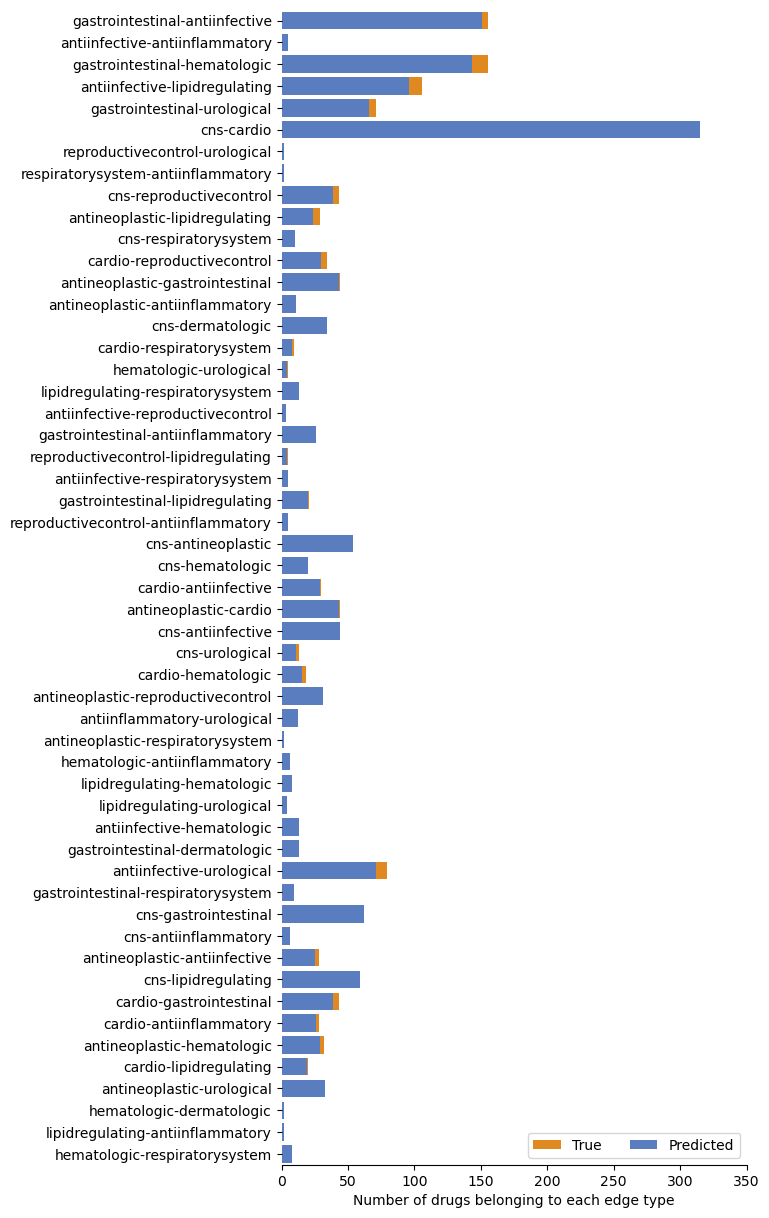

In [438]:
fig, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
# sns.set_color_codes("pastel")
sns.barplot(x="num_true_edges", y="edge_type", data=df,
            label="True", color="darkorange")

# Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
sns.barplot(x="num_predicted_edges", y="edge_type", data=df,
            label="Predicted", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 350), ylabel="",
       xlabel="Number of drugs belonging to each edge type")
sns.despine(left=True, bottom=False)
# ax.set_yticks(ticks=[])
# ax.grid(True)
fig.savefig("images/EdgeCount.png", bbox_inches='tight', dpi=95)
plt.show()


In [52]:
def draw_rel_graph(edges, num_classes=NUM_CLASSES, colors=COLORS_, fname="images/TrueNetRel.png"):
    labels = {}
    for i, label in enumerate(CATEGORIES_SHORT):
        labels[i] = label
        
    edgelist = [edge for edge in edges]
    widths = [0.5*float(np.log2(int(edges[edge]) + 1)) for edge in edges] 

    G = nx.Graph()
    for node in np.arange(0, num_classes):
        G.add_node(node)

    for i, edge in enumerate(edges):
        G.add_weighted_edges_from([(edge[0], edge[1], widths[i])])
    
    plt.figure(figsize=(8, 8), dpi=80,)
    pos = nx.circular_layout(G) 
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=3000)
    nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color="white")
    nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=widths)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(fname) 
    plt.show()
    return None

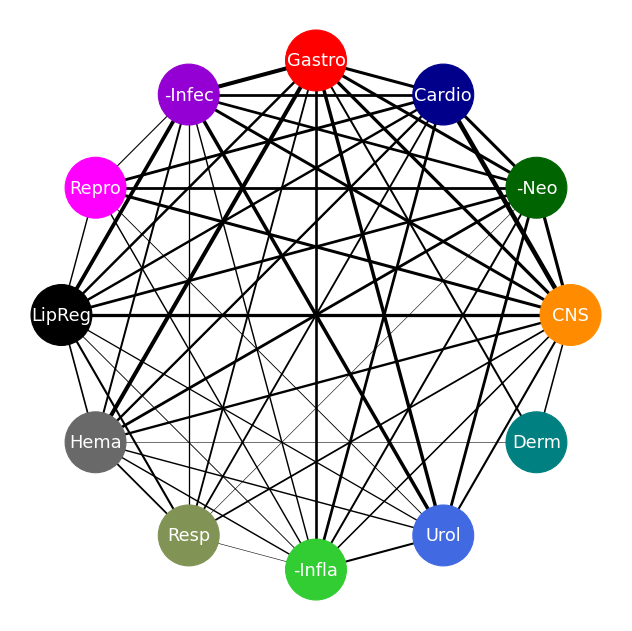

In [53]:
draw_rel_graph(edges=true_edges, fname="images/TrueNetRel.png")

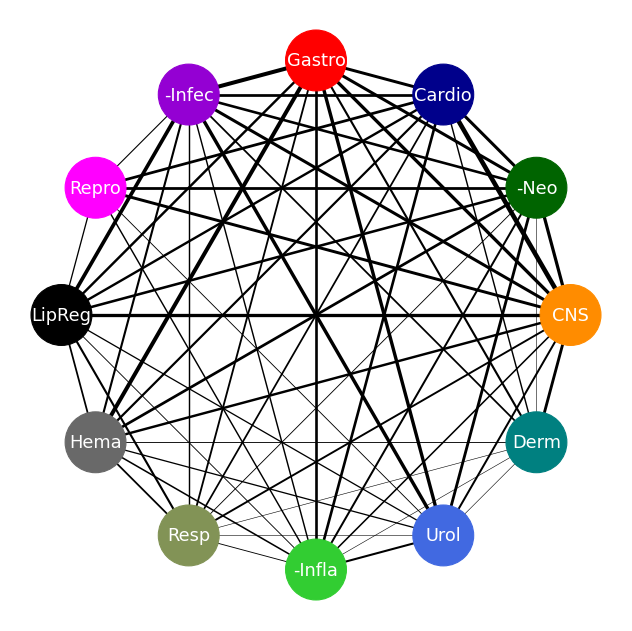

In [54]:
draw_rel_graph(edges=pred_edges, fname="images/PredNetRel.png")

In [53]:
def get_compound_name(smiles):
    try:
        c = get_compounds(smiles, "smiles")
        c = c[0]
        try:
            syns = c.synonyms
            name = syns[0]
            return name
        except:
            try:
                name = c.iupac_name
                return name
            except Exception as e:
                print(e)
                return None
    except Exception as e:
        print(e)
        return None

In [54]:
def get_unique_edge_set(true_list, pred_list):
    x, y = list(true_list), list(pred_list)
    xs, ys = set(x), set(y)
    xys = xs.union(ys)
    xy = sorted(list(xys))

    xye = list(itertools.combinations(xy, 2))
    xe = list(itertools.combinations(x, 2))

    xyes, xes = set(xye), set(xe)
    diff = xyes - xes
    return diff

In [55]:
def get_column_names(true_list, edge):
    first_col, second_col = None, None
    if edge[0] in true_list:
        first_col, second_col = edge[0], edge[1]
    else:
        first_col, second_col = edge[1], edge[0]
    return first_col, second_col

In [56]:
baicalin_true, baicalin_pred = true_labels[2347], pred_labels[2347]

In [57]:
baicalin_true, baicalin_pred

([0, 1, 10], [0, 7, 11])

In [58]:
bai_true = get_unique_edge_set(baicalin_true, baicalin_pred)

In [67]:
bai_true

{(0, 7), (0, 11), (1, 7), (1, 11), (7, 10), (7, 11), (10, 11)}

In [59]:
for edge in bai_true:
    first_col, second_col = get_column_names(baicalin_true, edge)
    print(f'[+] True label: {first_col} | Predicted label: {second_col}')

[+] True label: 0 | Predicted label: 7
[+] True label: 10 | Predicted label: 11
[+] True label: 1 | Predicted label: 11
[+] True label: 10 | Predicted label: 7
[+] True label: 1 | Predicted label: 7
[+] True label: 11 | Predicted label: 7
[+] True label: 0 | Predicted label: 11


In [60]:
def get_label_names(data):
    return mlb.inverse_transform(data.y.long().reshape(-1, 12).numpy())[0]

In [61]:
get_label_names(testdataset[2347])[0]

'antiinfective'

In [62]:
tpreds[2347]

tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

In [63]:
ttargets[2347]

tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [103]:
def save_predictions(true_edges, pred_edges, dataset=testdataset):
    filename = "data/PredictedSMILES.csv"
    
    try:
        os.remove(filename)
        print(f"[+] Deleting old file: {filename}")
    except OSError:
        print(f"[+] Saving a new list at: {filename}")
    
    with open(filename, 'a+') as f:
        line = "DRUGID,NAME,TRUE_LABELS,PREDICTED_LABELS,SMILES\n"
        f.write(line)
        
        for i, (tedge, pedge) in enumerate(zip(true_edges, pred_edges)):
            if tedge != pedge and len(tedge) > 1: 
                true_label_names = target_names[i]
                pred_label_names = pred_names[i]
                smiles = dataset[i].smiles
                print(smiles)
                name = get_compound_name(smiles)
                print(f"{name} \n")                 
                if name is None:
                    pass
                else:
                    if "," in name or ")" in name or "(" in name:
                        pass
                    else:
                        for (tname, pname) in zip(true_label_names, pred_label_names):
                            first_col_name = CATEGORIES_SHORT[CATEGORIES[tname]]
                            second_col_name = CATEGORIES_SHORT[CATEGORIES[pname]]

                            if "-" in first_col_name:
                                first_col_name = "Anti"+ first_col_name
                            if "-" in second_col_name:
                                second_col_name = "Anti"+ second_col_name
                            line = f"{i},{name},{first_col_name},{second_col_name},{smiles}\n"
                            f.write(line)
    return None

In [104]:
save_predictions(true_edges=true_labels, pred_edges=pred_labels, dataset=testdataset)

[+] Deleting old file: data/PredictedSMILES.csv
CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C(=O)C(C(N)=O)=C(O)[C@@]3(O)C(=O)C1=C2O
Sarecycline 

NC(=[NH2+])c1ccc2cc(OC(=O)c3ccc([NH+]=C(N)N)cc3)ccc2c1
[4-[6-[amino(azaniumylidene)methyl]naphthalen-2-yl]oxycarbonylphenyl]-(diaminomethylidene)azanium 

Cc1cn([C@H]2C[C@H](O)[C@@H](CON)O2)c(=O)[nH]c1=O
5'-o-aminothymidine 

O=C1c2cccc3c2[C@H](CCC3)CN1[C@H]1CN2CCC1CC2
Palonosetron, (3R)- 

CCC(C)[C@H](N)C1=NCC(C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](CCC(=O)O)C(=O)N[C@H](C(=O)N[C@H]2CCCCNC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](CC(=O)O)NC(=O)[C@H](Cc3cnc[nH]3)NC(=O)[C@@H](Cc3ccccc3)NC(=O)[C@H](C(C)CC)NC(=O)[C@@H](CCCN)NC2=O)C(C)CC)S1.NC[C@@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@@H](O[C@@H]3[C@@H](O)[C@H](N)C[C@H](N)[C@H]3O[C@H]3O[C@H](CN)[C@@H](O)[C@H](O)[C@H]3N)[C@@H]2O)[C@H](N)[C@@H](O)[C@@H]1O
Nebacetin 

CCC[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CS)NC(=O)[C@H](N)Cc1ccc2ccccc2c1)C(=O)N[C@@H](CS)C(=O)N[C@H](C(N

Psoralen 

Nc1ncnc2[nH]ncc12
1H-Pyrazolo[3,4-d]pyrimidin-4-amine 

CN(C)CCON=C(C=Cc1ccc(O)cc1)c1ccccc1F
Eplivanserin 

CSCC[C@@H](NC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)NCC(=O)N[C@@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(N)=O
CHEMBL4095111 

COC(CN1CCN(CC(O)C(OC)c2ccccc2)CC1)c1ccccc1
Zipeprol 

CC(=O)OC1CC(C)CCC1C(C)C.CC(C)=C1CCC(C)CC1=O.CC1CCC(C(C)C)C(=O)C1.CC1CCC(C(C)C)C(O)C1.CC1CCC2(CC1)OCC2C.Cc1coc2c1CCC(C)C2
PEPPERMINT OIL 

O=C(O)[C@H]1O[C@@H](Oc2cc3oc(-c4ccccc4)cc(=O)c3c(O)c2O)[C@H](O)[C@@H](O)[C@@H]1O
Baicalin 

Cc1cc(=O)c2c(O)c3c(O)cc(O)c4c5c(O)cc(O)c6c(O)c7c(=O)cc(C)c8c1c2c(c34)c(c65)c78
hypericin 

CCC(=O)C(C[C@H](C)N(C)C)(c1ccccc1)c1ccccc1.CCC(=O)C(C[C@H](C)N(C)C)(c1ccccc1)c1ccccc1
UNII-UC6VBE7V1Z 

O=c1[nH]sc2ccccc12
1,2-Benzisothiazol-3(2H)-one 

CN(C)CCN(Cc1ccccc1)c1ccccc1
PHENBENZAMINE 

CN(C)c1ccc([C@H]2C[C@]3(C)[C@@H](CC[C@]3(O)CCCO)[C@@H]3CCC4=CC(=O)CCC4=C32)cc1
Onapristone 

O=C1c2cccc3c2[C@H](CCC3)CN1[C@@H]1CN2CCC1CC2
Palonosetron 

Cc1ncc(CO)c(C)c1O
4-Deoxypyridoxine 

CN(C)CCO/

In [105]:
data = pd.read_csv("data/PredictedSMILES.csv")
df = pd.DataFrame(data)

In [106]:
df

DRUGID                 NAME TRUE_LABELS PREDICTED_LABELS  \
0         0          Sarecycline  Anti-Infec       Anti-Infec   
1         0          Sarecycline        Derm             Urol   
2        64  5'-o-aminothymidine  Anti-Infec       Anti-Infec   
3        64  5'-o-aminothymidine    Anti-Neo             Urol   
4       107            Nebacetin  Anti-Infec       Anti-Infec   
..      ...                  ...         ...              ...   
202    2941           Artesunate    Anti-Neo             Urol   
203    2955                 PDMP  Anti-Infec       Anti-Infec   
204    2955                 PDMP    Anti-Neo           Cardio   
205    3016             130-95-0  Anti-Infec       Anti-Infec   
206    3016             130-95-0         CNS           Cardio   

                                                                                                                                                                                                                                                                                                                                                                                                    SMILES  
0                                                                                                                                                                                                                                                                                                                     CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C(=O)C(C(N)=O)=C(O)[C@@]3(O)C(=O)C1=C2O  
1                                                                                                                                                                                                                                                                                                                     CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C(=O)C(C(N)=O)=C(O)[C@@]3(O)C(=O)C1=C2O  
2                                                                                                                                                                                                                                                                                                                                                         Cc1cn([C@H]2C[C@H](O)[C@@H](CON)O2)c(=O)[nH]c1=O  
3                                                                                                                                                                                                                                                                                                                                                         Cc1cn([C@H]2C[C@H](O)[C@@H](CON)O2)c(=O)[nH]c1=O  
4    CCC(C)[C@H](N)C1=NCC(C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](CCC(=O)O)C(=O)N[C@H](C(=O)N[C@H]2CCCCNC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](CC(=O)O)NC(=O)[C@H](Cc3cnc[nH]3)NC(=O)[C@@H](Cc3ccccc3)NC(=O)[C@H](C(C)CC)NC(=O)[C@@H](CCCN)NC2=O)C(C)CC)S1.NC[C@@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@@H](O[C@@H]3[C@@H](O)[C@H](N)C[C@H](N)[C@H]3O[C@H]3O[C@H](CN)[C@@H](O)[C@H](O)[C@H]3N)[C@@H]2O)[C@H](N)[C@@H](O)[C@@H]1O  
..                                                                                                                                                                                                                                                                                                                                                                                                     ...  
202                                                                                                                                                                                                                                                                                                                       C[C@H]1CC[C@H]2[C@H](C)[C@@H](OC(=O)CCC(=O)O)O[C@H]3O[C@@]4(C)CC[C@@H]1[C@]32OO4  
203                                             

In [65]:
from pyvis.network import Network

In [66]:
net = Network(directed=False, layout=None, 
                  height='1080px', width='1920px', 
                  bgcolor='white',
                  font_color='white',
                  notebook=True) #bgcolor=#222222 font_color='white', font_color='white',height='1536px', width=' 2048px', 

#set the physics layout of the network
# net.force_atlas_2based(spring_length=25)
data = pd.read_csv("data/MisclassifiedDrugs.csv")
df = pd.DataFrame(data)
drugs = df["NAME"].tolist() 
smiles = df["SMILES"].tolist() 
groupsA = df["TRUE_LABELS"].tolist() 
groupsB = df["PREDICTED_LABELS"].tolist() 

import difflib

for drug, sms, catA, catB in zip(drugs, smiles, groupsA, groupsB):
    src = drug.strip()
    dst = catA.strip()
    w = 0.1  
    
    all_nodes = [node["title"] for node in net.nodes]
    # check if drug is already  in the network:
    if src in all_nodes:
        pass
    else:
        net.add_node(src, src, title=src, shape='box', color='#1496BB') # , color='maroon' , size=20
        all_nodes = [node["title"] for node in net.nodes]
    
    # check if cat A is already  in the network:
    if dst in all_nodes:
        net.add_edge(src, dst)# , value=w
    else:
        descr = difflib.get_close_matches(dst, CATEGORIES_SHORT)[0]
        color = COLORS_[CATEGORIES_SHORT.index(descr)]
        net.add_node(dst, dst, title=dst, shape='circle', color=color)
        net.add_edge(src, dst)
        all_nodes = [node["title"] for node in net.nodes]

    dst = catB.strip()
    # check if cat B is already  in the network:
    if dst in all_nodes:
        net.add_edge(src, dst) # , value=w
    else:
        descr = difflib.get_close_matches(dst, CATEGORIES_SHORT)[0]
        color = COLORS_[CATEGORIES_SHORT.index(descr)]
        net.add_node(dst, dst, title=dst, shape='circle', color=color)
        net.add_edge(src, dst)
        all_nodes = [node["title"] for node in net.nodes]
        
neighbor_map = net.get_adj_list()

#     # add neighbor data to node hover data
#     for node in net.nodes:
#         node['label'] = CATEGORIES_SHORT[CATEGORIES[node['title']]]
#         node["color"] = COLORS[CATEGORIES[node['title']]]
#         node['title'] += ' Neighbors:<br>' + '<br>'.join(str(x) for x in list(neighbor_map[node['id']]))
#     #     node['value'] = len(neighbor_map[node['id']])

color_set = {node['id']:node['color'] for node in net.nodes }

for node in net.nodes:
    node['font']['size'] = 36
    node['label'] = node['title']
    node['title'] += ' Neighbors:<br>' + '<br>'.join(str(x) for x in list(neighbor_map[node['id']]))
#     node["color"] = COLORS[CATEGORIES[node['title']]]
#     node['shape'] = 'circle'

for edge in net.edges:
    dst_id = edge['to']
    edge['color'] = color_set[dst_id]

net.hrepulsion(node_distance=230, central_gravity=0.3, spring_length=200, spring_strength=0.005, damping=0.09)
# net.repulsion(node_distance=200, central_gravity=0.0, spring_length=200, spring_strength=0.005, damping=0.09)
# net.barnes_hut(gravity=-800, central_gravity=0.3, spring_length=150, spring_strength=0.01, damping=0.09, overlap=0)
# net.force_atlas_2based(gravity=-10, central_gravity=0.01, spring_length=150, spring_strength=0.08, damping=0.4, overlap=0)


# net.show_buttons(filter_=['edges'])
net.show('predictions.html')